In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [ ]:
# Set paths and hyperparameters
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = '/content'

device = 'cuda'

epochs = 25
lr = 0.003
img_size = 320
batch_size = 16

encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

In [ ]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks 

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/ 255.0

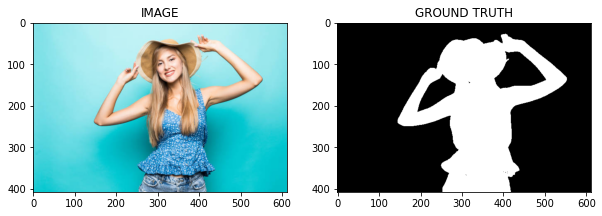

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [ ]:
# we need to apply augmentation on images as well as labels
import albumentations as A

In [ ]:
def get_train_augs():
    return A.Compose([A.Resize(img_size, img_size), A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)])


def get_valid_augs():
    return A.Compose([A.Resize(img_size, img_size)])


In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
    
    def __init__(self, df, augmentations):

        self.df = df
        self.augmentations = augmentations

    def __len__(self):

        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        image_path = row.images
        mask_path = row.masks
        image =cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # here, the mask has dimension (h, w). we need to expand it to (h, w, 1)
        mask = np.expand_dims(mask, axis = -1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask) # dictionary
            image = data['image']
            mask = data['mask']

        # convert from (h, w, c) to (c, h, w) as pytorch needs it in c, h, w
        image = np.transpose(image, (2, 0, 1)).astype(np.float32) # the order in which we want the axis
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image)/255.0
        mask = torch.round(torch.Tensor(mask)/255.0)

        return image, mask


In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


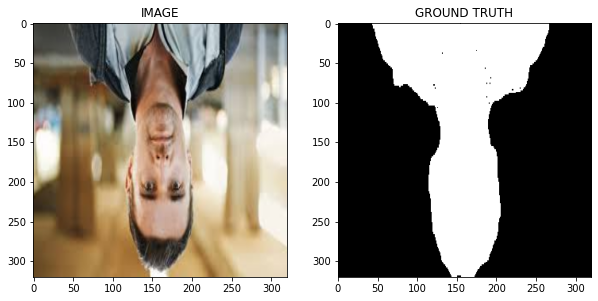

In [ ]:
idx = 32
image, mask = trainset[idx]
helper.show_image(image, mask)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [ ]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
    break

print(f"one batch image shape : {image.shape}")
print(f"one batch mask shape : {mask.shape}")


one batch image shape : torch.Size([16, 3, 320, 320])
one batch mask shape : torch.Size([16, 1, 320, 320])


In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()   # basic code to create model in pytorch
        self.arc = smp.Unet(encoder_name=encoder, 
                            encoder_weights=weights, 
                            in_channels=3, # in channels are RGB so 3
                            classes=1, # binary segmentation
                            activation= None
                            )
        
    def forward(self, images, masks=None):

        logits = self.arc(images)
        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        else:
            return logits




In [ ]:
model = SegmentationModel()
model.to(device);

In [ ]:
def train_model(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        # it is necessary to zero out the gradients of a tensor since they are accumulated in buffers and not 
        # overwritten every time backward() is called.
        # for eg: when you start the training loop, the gradients should be zeroed out
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(data_loader)  # avg loss = total loss / no. of batches

In [ ]:
def eval_model(data_loader, model): # just like above but without optimizer step as we dont need weight update
    model.eval()    # without any dropout layer
    total_loss = 0.0

    with torch.no_grad():   # no gradient computation for this

        for images, masks in tqdm(data_loader):
            images = images.to(device)
            masks = masks.to(device)
        
            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss/len(data_loader)  # avg loss = total loss / no. of batches

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
best_valid_loss = np.Inf

for i in range(epochs):
    train_loss = train_model(trainloader, model, optimizer)
    valid_loss = eval_model(validloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("Saved Model")
        best_valid_loss = valid_loss

    print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Saved Model
Epoch : 1 Train_loss : 0.7985822180906932 Valid_loss : 4.456897795200348


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Saved Model
Epoch : 2 Train_loss : 0.3664536903301875 Valid_loss : 0.3823886960744858


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Saved Model
Epoch : 3 Train_loss : 0.321675044298172 Valid_loss : 0.32190608233213425


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Saved Model
Epoch : 4 Train_loss : 0.25842839032411574 Valid_loss : 0.22778039798140526


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch : 5 Train_loss : 0.23805492818355561 Valid_loss : 0.2509301193058491


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 6 Train_loss : 0.21586744884649914 Valid_loss : 0.23644468560814857


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Saved Model
Epoch : 7 Train_loss : 0.1944786588350932 Valid_loss : 0.2071247473359108


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Saved Model
Epoch : 8 Train_loss : 0.17429518898328145 Valid_loss : 0.2070229910314083


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


Epoch : 9 Train_loss : 0.17533306479454042 Valid_loss : 0.22797725349664688


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 10 Train_loss : 0.150113445520401 Valid_loss : 0.21204078197479248


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch : 11 Train_loss : 0.16486128568649291 Valid_loss : 0.24723713472485542


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch : 12 Train_loss : 0.1776251683632533 Valid_loss : 0.23220393434166908


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch : 13 Train_loss : 0.20693009942770005 Valid_loss : 0.23007358238101006


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch : 14 Train_loss : 0.16483092606067656 Valid_loss : 0.22899392992258072


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Saved Model
Epoch : 15 Train_loss : 0.14732590168714524 Valid_loss : 0.1942053660750389


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Saved Model
Epoch : 16 Train_loss : 0.12657083322604498 Valid_loss : 0.17575269378721714


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Epoch : 17 Train_loss : 0.11772993306318918 Valid_loss : 0.21401556581258774


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epoch : 18 Train_loss : 0.12864353011051813 Valid_loss : 0.22427889704704285


 50%|█████     | 2/4 [00:00<00:00,  4.66it/s]

In [ ]:
idx = 29

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(device).unsqueeze(0))  # (c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)* 1.0 

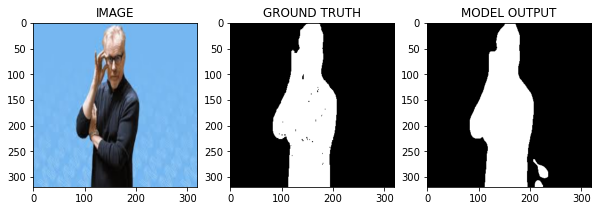

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))